# DEFINE GENERAL METHODS AND PARAMETERS




## IMPORT ALL NEEDED LIBRARIES

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import os
import time
from math import log, e
import math

## DEFINE STRUCTURAL METHODS

In [2]:
# Function to evaluate the entropy of a vector
# INPUTS
# - labels: vector to compute entropy
# - base: base of the log for the computation of entropy
# OUTPUT: entropy values
def compute_entropy(labels, base=None):

  n_labels = len(labels)

  if n_labels <= 1:
    return 0

  value,counts = np.unique(labels, return_counts=True)
  probs = counts / n_labels
  n_classes = np.count_nonzero(probs)

  if n_classes <= 1:
    return 0

  ent = 0.

  # Compute entropy
  base = e if base is None else base
  for i in probs:
    ent -= i * log(i, base)

  return ent

# Function to evaluate the entropy of a file as a function of the header length
# INPUTS
# - file: the file we want to anlyze (formats as an integer vector)
# OUTPUT: vector that contains the entropy values as a function of the header length analyzed

def entropy_analysis(file):

  num_bytes = math.ceil(len(file)/8)
  headers_entropy = np.zeros(num_bytes)

  for i in range(num_bytes):
      headers_entropy[i] = compute_entropy(labels=file[0:8*(i+1)],base=2)

  return headers_entropy

# Function to evaluate the differential area (DDA approach) between two file's entropies 
# INPUTS
# - file_1,file_2: vectors obtained with entropy_analysis function
# OUTPUT: value of the differential area
def differential_area(header_entropy_1,header_entropy_2):

    length = min(len(header_entropy_1),len(header_entropy_2))
    differential_vector = np.zeros(length)

    for i in range(length):
        differential_vector[i]=abs(header_entropy_1[i]-header_entropy_2[i])
    
    sum = 0
    for i in range(1,length-1):
        sum = sum+2*differential_vector[i]

    return (8/2)*(differential_vector[0]+differential_vector[-1]+sum)

# Function that evaluate if the file is classified as ransomware
# INPUTS
# - treshold: value to classify the file
# - area: trapezoidal area of the file
# OUTPUT: accur = 1.0 (correctly classified) accur = 0.0 (misclassified)
def compute_accuracy(threshold, area):
    accur = 0.0

    #True positive (TP)
    if area <= threshold:
      accur = 1.0
    
    return accur

# Function that compute the differential trapezoidal area between an ideal and a real file
# INPUTS
# - ideal_file: file of given bytes completely random
# - file_vector: vectorialized version of the file, unit8 format
# OUTPUT: differential area between ideal and consider file
def trapezoidal_rule(file_vector, ideal_entropy):
    file_entropy = entropy_analysis(file_vector)
    return differential_area(file_entropy,ideal_entropy)

# Function that divides the file in num_fragms segments and select a random best_hl bytes subpart from each segment
# INPUTS
# - file: file that we are analyzing
# - num_frams: parameter that set the different type of analysis
# - best_hl: best header length to classify to compute the entropy, founded in best_model.ipynb
# - ideal_entropy: entropy of an ideal file with length best_hl previously computed
# OUTPUT: areas of consider file
def get_areas(file, num_fragms, best_hl, ideal_entropy):

    begin = start = 0
    i = 1
    bound = len(file) // num_fragms

    if len(file) < num_fragms * best_hl:
        bound = len(file) // (len(file) // best_hl)

    areas = []
    while i <= num_fragms and len(file) >= i*best_hl and start < len(file) - best_hl:
        file_vector = file[start:start+best_hl]
        areas.append(trapezoidal_rule(file_vector,ideal_entropy))
        begin = start + best_hl
        if begin >= len(file) - best_hl:
            begin = i * bound
        if i == num_fragms and begin < len(file) - best_hl:
            #start = random.randint(begin, len(file) - best_hl -1)
            if begin < len(file) - best_hl -1:
                start = random.randint(begin, len(file) - best_hl -1)
            elif begin == len(file) - best_hl -1:
                start = begin
        else:
            #start = random.randint(begin, (i+1) * bound - best_hl)
            if begin < (i+1) * bound - best_hl -1:
                start = random.randint(begin, (i+1) * bound - best_hl -1)
            elif begin == (i+1) * bound - best_hl -1:
                start = begin
        i+=1

    return areas

# Function that update the accuracies and error statistics
# INPUTS
# - acc: matrix of accuracies, also known as true positive (correctly classified ransomwares)
# - sequence_length: index of the length sequence value for which we are computing accuracy
# - jump: index of the jump value for which we are computing accuracy
# - best_tresh: best threshold for the considere analysis, computed in best_model.ipynb
# - best_area : smaller area found with avg or max get_best_area methods
# OUTPUT: void, just update the matrices acc and false_negatives
def update_statistics(acc, sequence_length, jump, best_thresh, best_area):

    result = compute_accuracy(best_thresh, best_area)
    acc[sequence_length][jump] = acc[sequence_length][jump] + result

    return

# Function that lower the entropy of a ransomware file by inserting equal bytes into it
# INPUTS
# - file: file to modify
# - random_values : values that will be inserted into the file
# - sequence_length: length of the random bytes sequence to insert into the file
# - jump: distance between each injection of random bytes
# OUTPUT: modified file with the requested length sequence and jump
def modify_file(file, random_values, jump):

    modified_file = []

    for i in range(0,len(file),jump):
        modified_file += list(file[i:i+jump]) + random_values

    return modified_file

## DEFINE STRESS TESTS

In [3]:
def perform_stress_test(stress_test_params,model_params,files_path):

  sequence_lengths = stress_test_params["sequence_lengths"]
  jumps = stress_test_params["jumps"]
  acc = np.zeros([len(sequence_lengths), len(jumps)], dtype = float) #initialyze results matrix
  files_analyzed = np.zeros([len(sequence_lengths), len(jumps)])
  
  #Perform the analysis
  start_time = time.time()

  print("Starting the analysis")

  for sequence_length in range(len(sequence_lengths)):

    print("--- Analysis for sequence length %s ---" % (sequence_lengths[sequence_length]))
    time_analysis = time.time()
    random_value = random.randint(0, 255)
    random_values = [random_value for i in range(sequence_lengths[sequence_length])]

    for jump in range(len(jumps)):

      for file_path in range(len(files_path)):
        
        file = np.fromfile(files_path[file_path], dtype=np.uint8)

        if(sequence_lengths[sequence_length] != 0): modified_file = modify_file(file, random_values,jumps[jump])
        else : modified_file = file

        if len(modified_file) >= model_params["num_fragms"]*model_params["best_hl"]:
          areas = get_areas(modified_file,model_params["num_fragms"],model_params["best_hl"],model_params["ideal_entropy"])
          best_area = get_best_area(areas,model_params["best_dist"])
          update_statistics(acc,sequence_length,jump,model_params["best_thresh"],best_area)
          files_analyzed[sequence_length][jump] += 1

  acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

  time_spent = time.time() - start_time
  print("Time for the analysis of the dataset")
  print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))
  return acc


In [4]:
def perform_stress_test_2F(stress_test_params,model_params,files_path):

  sequence_lengths = stress_test_params["sequence_lengths"]
  jumps = stress_test_params["jumps"]
  acc = np.zeros([len(sequence_lengths), len(jumps)], dtype = float) #initialyze results matrix
  files_analyzed = np.zeros([len(sequence_lengths), len(jumps)])
  
  #Perform the analysis
  start_time = time.time()

  print("Starting the analysis")

  for sequence_length in range(len(sequence_lengths)):

    print("--- Analysis for sequence length %s ---" % (sequence_lengths[sequence_length]))
    time_analysis = time.time()
    random_value = random.randint(0, 255)
    random_values = [random_value for i in range(sequence_lengths[sequence_length])]

    for jump in range(len(jumps)):

      for file_path in range(len(files_path)):
        
        file = np.fromfile(files_path[file_path], dtype=np.uint8)

        if(sequence_lengths[sequence_length] != 0): modified_file = modify_file(file, random_values,jumps[jump])
        else : modified_file = file

        if len(modified_file) >= model_params["num_fragms"]*model_params["best_hl"]:
          areas = []
          areas.append(trapezoidal_rule(modified_file[0:model_params["best_hl"]], model_params["ideal_entropy"]))
          start = random.randint(model_params["best_hl"], len(modified_file) - model_params["best_hl"])
          areas.append(trapezoidal_rule(modified_file[start:start+model_params["best_hl"]], model_params["ideal_entropy"]))
          best_area = get_best_area(areas,model_params["best_dist"])
          update_statistics(acc,sequence_length,jump,model_params["best_thresh"],best_area)
          files_analyzed[sequence_length][jump] += 1

  acc = np.multiply(np.true_divide(acc, files_analyzed), 100.0, dtype=float)

  time_spent = time.time() - start_time
  print("Time for the analysis of the dataset")
  print("--- %s minutes, %s seconds, %s files analyzed ---" % (time_spent//60, ((time_spent)-60*((time_spent)//60))//1, np.sum(files_analyzed)))
  return acc

## DEFINE PLOT RESULTS METHOD

In [5]:
def plot_results(acc,stress_test_params, title):

  acc = np.transpose(acc) #transpose for graphical reasons
  sequence_lengths = stress_test_params["sequence_lengths"]
  jumps = stress_test_params["jumps"]
  n = len(jumps) #number of curves to plot = number of jumps
  
  color = cm.rainbow(np.linspace(0,1,n))
  plt.figure(figsize=(10,10))
  plt.title(title)
  plt.xlabel("Sequence lengths")
  plt.ylabel("Accuracy (%)")
  for i,c in zip(range(n),color):
    label = "Jumps length " + str(jumps[i])
    plt.plot(sequence_lengths, acc[i], c=c, label=label)
  plt.legend()
  plt.ylim([0, 100])
  plt.show()

  return

## CREATE LIST OF FILES' PATH

In [6]:
dataset = open('../paths/path_ransomwares.txt', 'r')
paths = dataset.readlines()
dataset.close()
files_path = []

for j in range(len(paths)):
  directories = os.listdir(paths[j][:-1]) # List all the directories in the paths[j]
  for file in range(len(directories)):
    full_path = paths[j][:-1] + "/" + str(directories[file])
    files_path.append(full_path)

## DEFINE PARAMS OF THE STRESS TEST: SEQUENCE LENGTHS AND JUMPS

In [7]:
sequence_start, sequence_end, sequence_step = 0,65,2 #sequence values to start, end, and step between each number
jump_start, jump_end, jump_step = 4,65,4 #jump values to start, end, and step between each number

stress_test_params = {
    "sequence_lengths" : np.arange(sequence_start,sequence_end,sequence_step), #generate array of such values, last values is sequence_end - 1
    "jumps" : np.arange(jump_start,jump_end,jump_step) #generate array of such values, last values is jump_end - 1
}

# STRESS TEST FOR AVG AREA

## DEFINE AVERAGE AREA METHOD

In [8]:
# Function that get the best area
# INPUTS
# - areas: previously computed areas from which we pick the best one
# - distance: parameter that allows the method to mitigate the Davies effect
# OUTPUT: area that better perform for the consider analysis
def get_best_area(areas, distance):

    best_area = 0
    mean_random_area = np.mean(areas[1:])

    if areas[0] - distance < mean_random_area:
      best_area = areas[0]
    else:
      best_area = min(areas[0], mean_random_area)
      
    return best_area

## 3F_AVG

### INITIALIZE PARAMETERS

In [8]:
num_fragms = 3 #type of analysis (3 for 3F, 4 for 4F)

#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_3F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(256/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

ideal_file = np.random.randint(0,256,best_hl) #ideal random file for comparison reason
ideal_entropy = entropy_analysis(ideal_file) #compute entropy of ideal file with best_hl

model_params = {
    "num_fragms" : num_fragms,
    "best_thresh" :  thresholds[ind[0]],
    "best_dist" : distances[ind[1]],
    "best_hl" : 8*(ind[2]+1),
    "ideal_entropy": ideal_entropy
}

### PERFORM THE STRESS TEST

In [9]:
acc_3F_avg = perform_stress_test(stress_test_params,model_params,files_path)

Starting the analysis
--- Analysis for sequence length 0 ---
--- Analysis for sequence length 2 ---
--- Analysis for sequence length 4 ---
--- Analysis for sequence length 6 ---
--- Analysis for sequence length 8 ---
--- Analysis for sequence length 10 ---
--- Analysis for sequence length 12 ---
--- Analysis for sequence length 14 ---
--- Analysis for sequence length 16 ---
--- Analysis for sequence length 18 ---
--- Analysis for sequence length 20 ---
--- Analysis for sequence length 22 ---
--- Analysis for sequence length 24 ---
--- Analysis for sequence length 26 ---
--- Analysis for sequence length 28 ---
--- Analysis for sequence length 30 ---
--- Analysis for sequence length 32 ---
--- Analysis for sequence length 34 ---
--- Analysis for sequence length 36 ---
--- Analysis for sequence length 38 ---
--- Analysis for sequence length 40 ---
--- Analysis for sequence length 42 ---
--- Analysis for sequence length 44 ---
--- Analysis for sequence length 46 ---
--- Analysis for sequen

### PLOT THE RESULTS

In [8]:
plot_results(acc_3F_avg,stress_test_params, title="3F")

NameError: name 'acc_3F_avg' is not defined

### SERIALIZE RESULTS IN A FILE

In [11]:
#save results of the best are computed with avg method in a file
np.save('../results/stress_test_acc_3F_avg.npy',acc_3F_avg)

## 4F_AVG

### INITIALIZE PARAMETERS

In [13]:
num_fragms = 4 #type of analysis (3 for 3F, 4 for 4F)

#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_3F_mix_avg.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(256/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

ideal_file = np.random.randint(0,256,best_hl) #ideal random file for comparison reason
ideal_entropy = entropy_analysis(ideal_file) #compute entropy of ideal file with best_hl

model_params = {
    "num_fragms" : num_fragms,
    "best_thresh" :  thresholds[ind[0]],
    "best_dist" : distances[ind[1]],
    "best_hl" : 8*(ind[2]+1),
    "ideal_entropy": ideal_entropy
}

### PERFORM THE STRESS TEST

In [14]:
acc_4F_avg = perform_stress_test(stress_test_params,model_params,files_path)

Starting the analysis
--- Analysis for sequence length 0 ---
--- Analysis for sequence length 2 ---
--- Analysis for sequence length 4 ---
--- Analysis for sequence length 6 ---
--- Analysis for sequence length 8 ---
--- Analysis for sequence length 10 ---
--- Analysis for sequence length 12 ---
--- Analysis for sequence length 14 ---
--- Analysis for sequence length 16 ---
--- Analysis for sequence length 18 ---
--- Analysis for sequence length 20 ---
--- Analysis for sequence length 22 ---
--- Analysis for sequence length 24 ---
--- Analysis for sequence length 26 ---
--- Analysis for sequence length 28 ---
--- Analysis for sequence length 30 ---
--- Analysis for sequence length 32 ---
--- Analysis for sequence length 34 ---
--- Analysis for sequence length 36 ---
--- Analysis for sequence length 38 ---
--- Analysis for sequence length 40 ---
--- Analysis for sequence length 42 ---
--- Analysis for sequence length 44 ---
--- Analysis for sequence length 46 ---
--- Analysis for sequen

### PLOT THE RESULTS

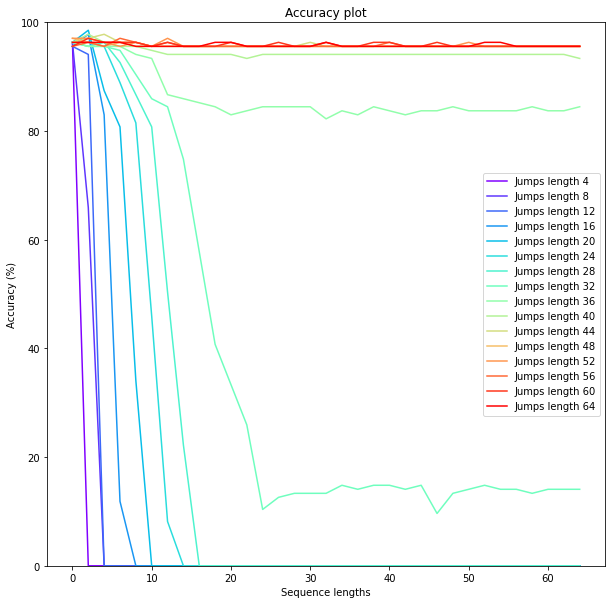

In [14]:
plot_results(acc_4F_avg,stress_test_params, title="4F avg")

### SERIALIZE RESULTS IN A FILE

In [16]:
#save results of the best are computed with avg method in a file
np.save('../results/stress_test_acc_4F_avg.npy',acc_4F_avg)

# STRESS TEST FOR MAX AREA


## DEFINE MAX AREA METHOD

In [18]:
# Function that get the best area between different fragments considered
# INPUTS
# - areas: previously computed areas from which we pick the best one
# - distance: parameter that allows the method to mitigate the Davies effect
# OUTPUT: area that better perfomr for the consider analysis
def get_best_area(areas, distance):

    best_area = 0
    rand_Fs_best_area = np.amax(areas[1:])

    if areas[0] - distance < rand_Fs_best_area:
        best_area = areas[0]
    else:
        best_area = min(areas[0], rand_Fs_best_area)
        
    return best_area

## 3F_MAX

### INITIALIZE PARAMETERS



In [19]:
num_fragms = 3 #type of analysis (3 for 3F, 4 for 4F)

#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_3F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(256/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

ideal_file = np.random.randint(0,256,best_hl) #ideal random file for comparison reason
ideal_entropy = entropy_analysis(ideal_file) #compute entropy of ideal file with best_hl

model_params = {
    "num_fragms" : num_fragms,
    "best_thresh" :  thresholds[ind[0]],
    "best_dist" : distances[ind[1]],
    "best_hl" : 8*(ind[2]+1),
    "ideal_entropy": ideal_entropy
}

### PERFORM THE STRESS TEST

In [20]:
acc_3F_max = perform_stress_test(stress_test_params,model_params,files_path)

Starting the analysis
--- Analysis for sequence length 0 ---
--- Analysis for sequence length 2 ---
--- Analysis for sequence length 4 ---
--- Analysis for sequence length 6 ---
--- Analysis for sequence length 8 ---
--- Analysis for sequence length 10 ---
--- Analysis for sequence length 12 ---
--- Analysis for sequence length 14 ---
--- Analysis for sequence length 16 ---
--- Analysis for sequence length 18 ---
--- Analysis for sequence length 20 ---
--- Analysis for sequence length 22 ---
--- Analysis for sequence length 24 ---
--- Analysis for sequence length 26 ---
--- Analysis for sequence length 28 ---
--- Analysis for sequence length 30 ---
--- Analysis for sequence length 32 ---
--- Analysis for sequence length 34 ---
--- Analysis for sequence length 36 ---
--- Analysis for sequence length 38 ---
--- Analysis for sequence length 40 ---
--- Analysis for sequence length 42 ---
--- Analysis for sequence length 44 ---
--- Analysis for sequence length 46 ---
--- Analysis for sequen

### PLOT THE RESULTS

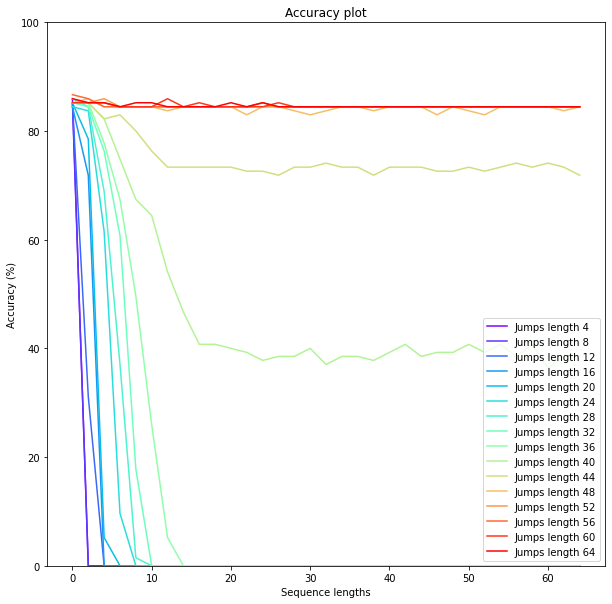

In [19]:
plot_results(acc_3F_max,stress_test_params, title="3F max")

### SERIALIZE RESULTS IN A FILE

In [22]:
#save results of the best are computed with max method in a file
np.save('../results/stress_test_acc_3F_max.npy',acc_3F_max)

## 4F_MAX

### INITIALIZE PARAMETERS

In [24]:
num_fragms = 4 #type of analysis (3 for 3F, 4 for 4F)

#retrieve the best threshold, distance and header length values previously computed
thresholds = np.arange(8,80,2)
distances = np.arange(30,70,2)
acc_des=np.load('../results/acc_4F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(256/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

ideal_file = np.random.randint(0,256,best_hl) #ideal random file for comparison reason
ideal_entropy = entropy_analysis(ideal_file) #compute entropy of ideal file with best_hl

model_params = {
    "num_fragms" : num_fragms,
    "best_thresh" :  thresholds[ind[0]],
    "best_dist" : distances[ind[1]],
    "best_hl" : 8*(ind[2]+1),
    "ideal_entropy": ideal_entropy
}

### PERFORM THE STRESS TEST

In [25]:
acc_4F_max = perform_stress_test(stress_test_params,model_params,files_path)

Starting the analysis
--- Analysis for sequence length 0 ---
--- Analysis for sequence length 2 ---
--- Analysis for sequence length 4 ---
--- Analysis for sequence length 6 ---
--- Analysis for sequence length 8 ---
--- Analysis for sequence length 10 ---
--- Analysis for sequence length 12 ---
--- Analysis for sequence length 14 ---
--- Analysis for sequence length 16 ---
--- Analysis for sequence length 18 ---
--- Analysis for sequence length 20 ---
--- Analysis for sequence length 22 ---
--- Analysis for sequence length 24 ---
--- Analysis for sequence length 26 ---
--- Analysis for sequence length 28 ---
--- Analysis for sequence length 30 ---
--- Analysis for sequence length 32 ---
--- Analysis for sequence length 34 ---
--- Analysis for sequence length 36 ---
--- Analysis for sequence length 38 ---
--- Analysis for sequence length 40 ---
--- Analysis for sequence length 42 ---
--- Analysis for sequence length 44 ---
--- Analysis for sequence length 46 ---
--- Analysis for sequen

### PLOT THE RESULTS

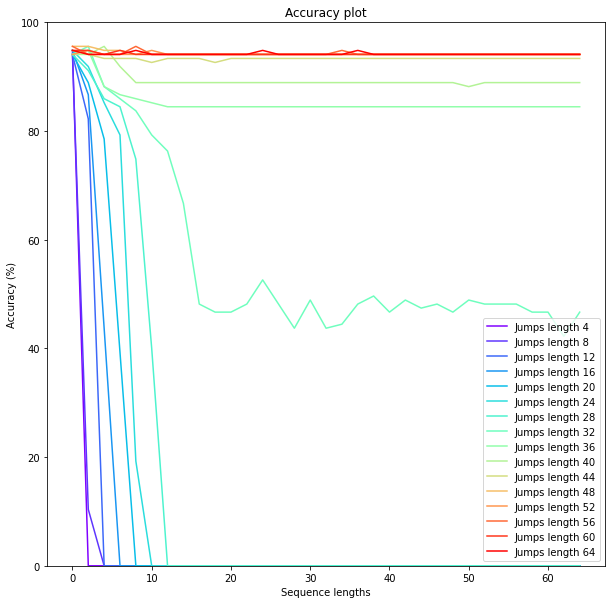

In [23]:
plot_results(acc_4F_max,stress_test_params, title="4F max")

### SERIALIZE RESULTS IN A FILE

In [27]:
#save results of the best are computed with max method in a file
np.save('../results/stress_test_acc_4F_max.npy',acc_4F_max)

## 2F

### INITIALIZE PARAMETERS

In [9]:
num_fragms = 2

thresholds = np.arange(8,80,2)
distances = np.arange(10,56,2)

acc_des=np.load('../results/acc_2F_mix.npy')
acc_des = acc_des.reshape(len(thresholds), len(distances), int(256/8))

ind = np.unravel_index(np.argmax(acc_des, axis=None), acc_des.shape)
best_thresh, best_dist, best_hl = thresholds[ind[0]], distances[ind[1]], 8*(ind[2]+1)

ideal_file = np.random.randint(0,256,best_hl) #ideal random file for comparison reason
ideal_entropy = entropy_analysis(ideal_file) #compute entropy of ideal file with best_hl

model_params = {
    "num_fragms" : num_fragms,
    "best_thresh" :  thresholds[ind[0]],
    "best_dist" : distances[ind[1]],
    "best_hl" : 8*(ind[2]+1),
    "ideal_entropy": ideal_entropy
}

### PERFORM THE STRESS TEST

In [10]:
acc_2F = perform_stress_test_2F(stress_test_params,model_params,files_path)

Starting the analysis
--- Analysis for sequence length 0 ---
--- Analysis for sequence length 2 ---
--- Analysis for sequence length 4 ---
--- Analysis for sequence length 6 ---
--- Analysis for sequence length 8 ---
--- Analysis for sequence length 10 ---
--- Analysis for sequence length 12 ---
--- Analysis for sequence length 14 ---
--- Analysis for sequence length 16 ---
--- Analysis for sequence length 18 ---
--- Analysis for sequence length 20 ---
--- Analysis for sequence length 22 ---
--- Analysis for sequence length 24 ---
--- Analysis for sequence length 26 ---
--- Analysis for sequence length 28 ---
--- Analysis for sequence length 30 ---
--- Analysis for sequence length 32 ---
--- Analysis for sequence length 34 ---
--- Analysis for sequence length 36 ---
--- Analysis for sequence length 38 ---
--- Analysis for sequence length 40 ---
--- Analysis for sequence length 42 ---
--- Analysis for sequence length 44 ---
--- Analysis for sequence length 46 ---
--- Analysis for sequen

### PLOT THE RESULTS

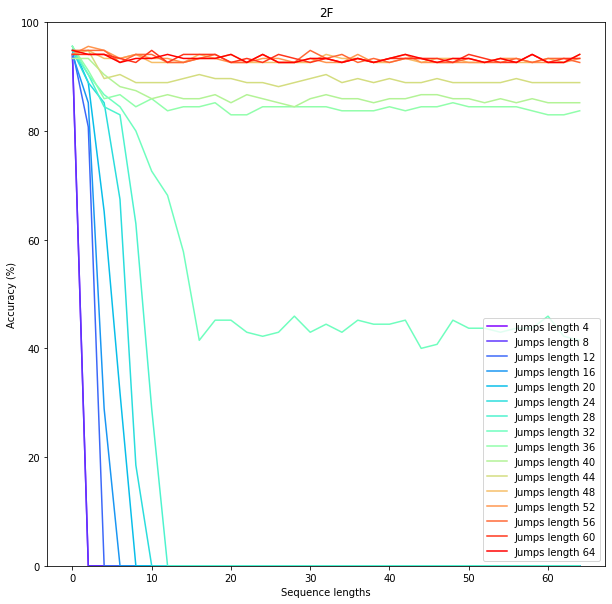

In [11]:
plot_results(acc_2F,stress_test_params, title="2F")

### SERIALIZE RESULTS IN A FILE

In [12]:
#save results of the best are computed with max method in a file
np.save('../results/stress_test_acc_2F.npy',acc_2F)

# RETRIEVE RESULTS

## DESERIALIZE RESULTS FROM FILES

In [13]:
#accuracies from avg best area methods

acc_3F_avg = np.load('../results/stress_test_acc_3F_avg.npy')
acc_4F_avg = np.load('../results/stress_test_acc_4F_avg.npy')

#accuracies from max best area methods

acc_3F_max = np.load('../results/stress_test_acc_3F_max.npy')
acc_4F_max = np.load('../results/stress_test_acc_4F_max.npy')

acc_2F = np.load('../results/stress_test_acc_2F.npy')

## PLOT ALL RESULTS

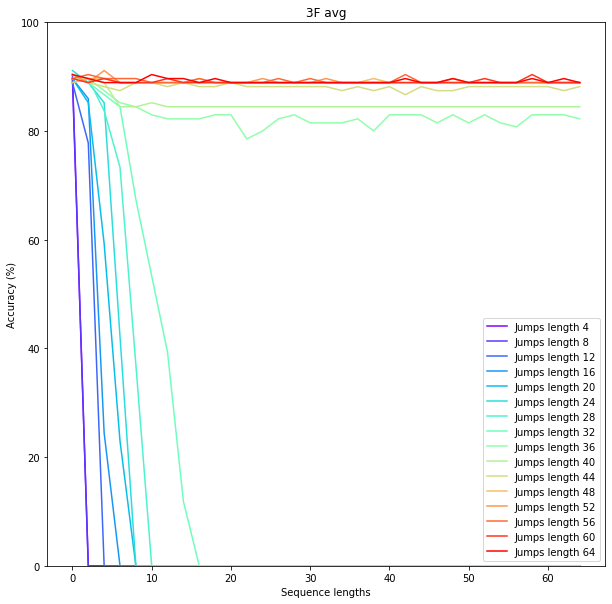

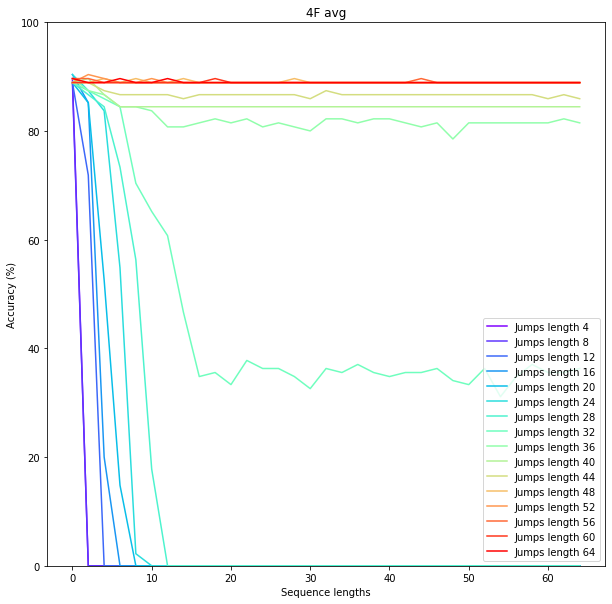

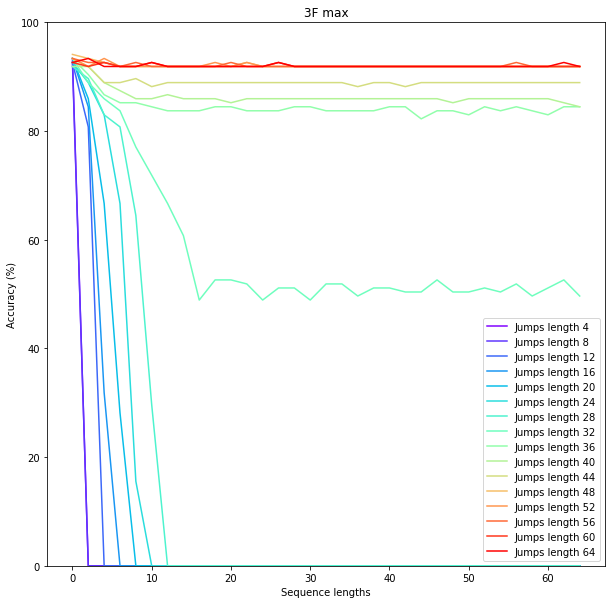

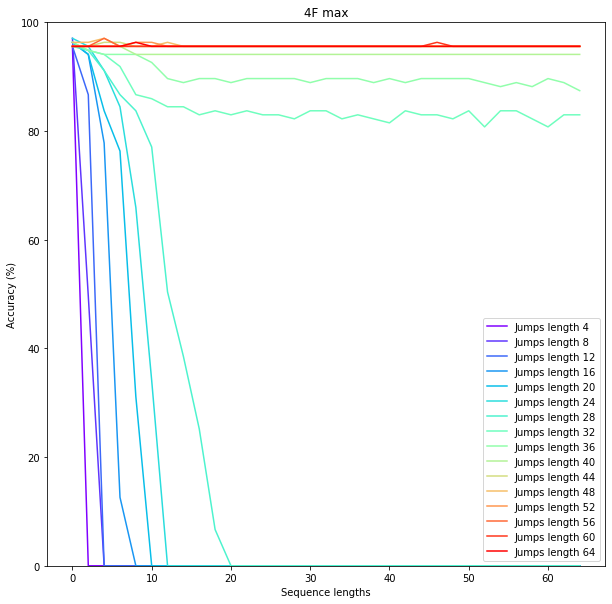

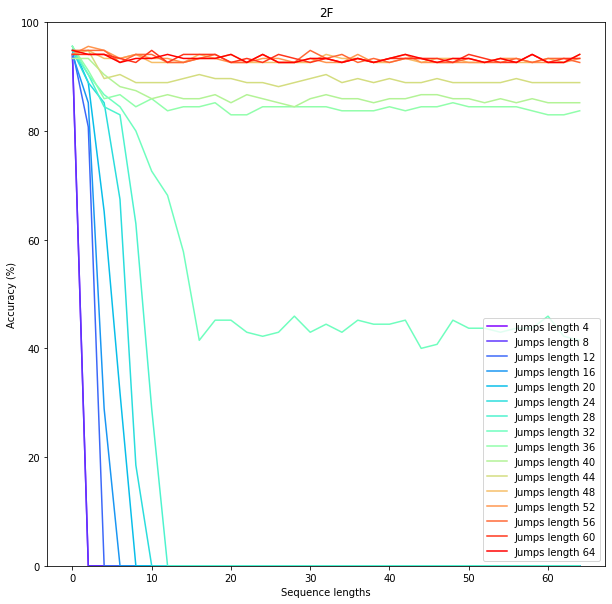

In [14]:
#plot for avg area method

plot_results(acc_3F_avg,stress_test_params, title="3F avg")
plot_results(acc_4F_avg,stress_test_params, title="4F avg")

#plot for avg area method

plot_results(acc_3F_max,stress_test_params, title="3F max")
plot_results(acc_4F_max,stress_test_params, title="4F max")


plot_results(acc_2F,stress_test_params, title="2F")

## FIND FIRST SEQUENCE LENGTH AND JUMP WITH ACCURACY LESS OR EQUAL THAN 80%

In [15]:
def find_seq_jump(acc, percentile, stress_test_params):
    max_j,min_i=0,0
    for j in range(acc.shape[1]):
        for i in range(acc.shape[0]):
            if(acc[i][j]<90):
                max_j = j
                min_i = i
                break

    print(acc[min_i][max_j])
    sequence_lengths = stress_test_params["sequence_lengths"]
    jumps = stress_test_params["jumps"]
    print(sequence_lengths[min_i],jumps[max_j])

### 3F_AVG

In [16]:
find_seq_jump(acc_3F_avg,90,stress_test_params)

89.62962962962962
2 64


### 4F_AVG

In [17]:
find_seq_jump(acc_4F_avg,90,stress_test_params)

89.62962962962962
0 64


### 3F_MAX

In [18]:
find_seq_jump(acc_3F_max,90,stress_test_params)

88.88888888888889
4 44


### 4F_MAX

In [19]:
find_seq_jump(acc_4F_max,90,stress_test_params)

89.62962962962962
12 36


### 2F

In [20]:
find_seq_jump(acc_2F,90,stress_test_params)

89.62962962962962
4 44
